# Single neuron TB

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import importlib
from spiker import *
from IPython.display import clear_output, Image, display, HTML
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_style('whitegrid')
# Test bench for Neuron
# Ip -> Neuron -> Syn -> Vsyn
Ts = 1e-6
transient_time = 0.1
def run_test(freq=5, amp=1e-9, periods = 1, plt = False, verbose=False):
    tstart = 0
    tstop = transient_time + periods/freq
    print(f'Running test with freq = {freq} and amplitude = {amp} for time {tstop}s' )
    
    tseries = gen_time(tstart,tstop,Ts)
    ipt     = gen_sine(tseries, freq, amp=amp)
    
    nspikes = np.zeros_like(tseries.time)
    nfbsyn  = np.zeros_like(tseries.time)

    ipt.set_time(0.)
    n = Neuronv2(1,Ts=Ts,
        ipItau   = 10e-12,
        ipIth    = 10e-12,
        fbItau   = 10e-12,
        fbIth    = 10e-12,
        fbdelta  = 0.01e-9,
        eItau    = 10e-12,
        eIth     = 100000e-12,
        thresh   = 0,  
        Kappa    = 0.7, 
        Temp     = 300,
        ipCmem   = 2e-12,
        fbCmem   = 2e-12,
        eCmem    = 2e-12,
        Tp       = Ts,
        mode     = 'sd',
        refr     = 1e-3,
        mismatch = 0)
    
    for index in range(len(tseries.time)):
        ip = ipt.value[index]
        nop = n.compute(ip)
        nspikes[index] = n.states[0]
        nfbsyn[index] = n.frecon[0]
    if plt:
        nspikes_t = Tseries(nspikes,tseries.time,Ts)    
        nfbsyn_t  = Tseries(nfbsyn,tseries.time,Ts)  
        nfbsyn_t.plot(0,tstop)
        ipt.plot(0,tstop)
    if verbose:
        n.print_props()
    return ipt.value, nfbsyn, n.spike_count/tstop

def compute_sdr(ip, Ts, plt = False, verbose=False):
    # Measuring the signal quality
    ip_fft = np.fft.fft(ip)
    N = len(ip_fft)
    ip_fft_psd = 2*np.abs(ip_fft)**2

    freqs = np.linspace(0.0, int(1.0/(2.0*Ts)), int(N/2))
    if plt:
        plt.semilogx(freqs, 10*np.log10(ip_fft_psd[:N//2]))
    max_id = 1+np.argmax(ip_fft_psd[1:N//2])
    peak_freq = freqs[max_id] 
    total_energy = np.sum(ip_fft_psd[1:N//2]) # discount the DC component
    distortion_energy = total_energy - ip_fft_psd[max_id]
    sdr = (ip_fft_psd[max_id])/distortion_energy
    sdr_db = 10*np.log10(sdr)
    if verbose:
        print(f'Peak frequency is {1+peak_freq} Hz')
        print(f'SDR in dB is {10*np.log10(sdr)}')
        print('='*89)
    return sdr_db

In [8]:
freqs = np.logspace(start=0, stop=5, num=20)
sdrs_f = np.zeros_like(freqs)
frates = np.zeros_like(freqs)
amp = 0.5e-9
for idx in range(len(freqs)):
    ip, nfb, frates[idx] = run_test(freq=freqs[idx], amp=amp, plt=False)
    sdrs_f[idx] = compute_sdr(nfb[int(transient_time/Ts):], Ts, verbose=True)

Running test with freq = 1.0 and amplitude = 5e-10 for time 1.1s
Peak frequency is 2.0000020000039997 Hz
SDR in dB is 28.277319482110958
Running test with freq = 1.8329807108324359 and amplitude = 5e-10 for time 0.6455594781168519s
Peak frequency is 2.8329923967475383 Hz
SDR in dB is 28.710555796907688
Running test with freq = 3.3598182862837818 and amplitude = 5e-10 for time 0.39763514416313184s
Peak frequency is 4.359853779163531 Hz
SDR in dB is 28.034793121282505
Running test with freq = 6.158482110660264 and amplitude = 5e-10 for time 0.2623776739188722s
Peak frequency is 7.158621454173698 Hz
SDR in dB is 29.718110903648455
Running test with freq = 11.28837891684689 and amplitude = 5e-10 for time 0.1885866790410083s
Peak frequency is 12.288720310665584 Hz
SDR in dB is 29.34774861756146
Running test with freq = 20.69138081114789 and amplitude = 5e-10 for time 0.14832930238571757s
Peak frequency is 21.692794768861482 Hz
SDR in dB is 26.491025312875642
Running test with freq = 37.9269

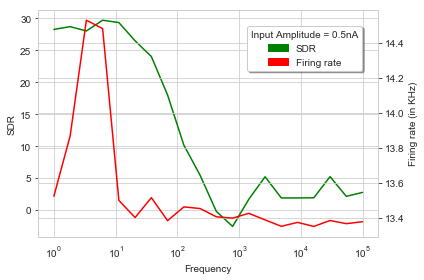

In [9]:
fig, ax1 = plt.subplots()

ax1.semilogx(freqs, sdrs_f, 'g' ,label='SDR')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('SDR')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.semilogx(freqs, frates/1e3, 'r', label='Firing rate')
ax2.set_ylabel('Firing rate (in KHz)')

title = f'Input Amplitude = {amp*1e9}nA'
patch1 = mpatches.Patch(color='g', label='SDR')
patch2 = mpatches.Patch(color='r', label='Firing rate')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.legend(handles=[patch1, patch2], title=title,loc='upper right',bbox_to_anchor=(0.85, 0.9), fancybox=True, shadow=True)
# plt.savefig('img/Nchar_freq_sweep.png',dpi=300)

In [10]:
amps = np.logspace(start=-12, stop=-6, num=20)
sdrs_amp = np.zeros_like(freqs)
freq=10
for idx in range(len(amps)):
    ip, nfb, frates[idx] = run_test(freq=freq, amp=amps[idx], plt=False)
    sdrs_amp[idx] = compute_sdr(nfb[int(transient_time/Ts):], Ts, verbose=True)

Running test with freq = 10 and amplitude = 1e-12 for time 0.2s
Peak frequency is 51.0010000200004 Hz
SDR in dB is -4.174512808740857
Running test with freq = 10 and amplitude = 2.06913808111479e-12 for time 0.2s
Peak frequency is 101.0020000400008 Hz
SDR in dB is -7.040290327120191
Running test with freq = 10 and amplitude = 4.281332398719396e-12 for time 0.2s
Peak frequency is 11.00020000400008 Hz
SDR in dB is -1.0017520566886549
Running test with freq = 10 and amplitude = 8.858667904100833e-12 for time 0.2s
Peak frequency is 11.00020000400008 Hz
SDR in dB is 5.792979420577126
Running test with freq = 10 and amplitude = 1.8329807108324375e-11 for time 0.2s
Peak frequency is 11.00020000400008 Hz
SDR in dB is 12.154063993269162
Running test with freq = 10 and amplitude = 3.7926901907322536e-11 for time 0.2s
Peak frequency is 11.00020000400008 Hz
SDR in dB is 18.486436186927083
Running test with freq = 10 and amplitude = 7.847599703514623e-11 for time 0.2s
Peak frequency is 11.000200004

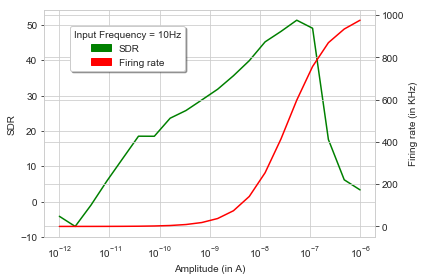

In [11]:
fig, ax1 = plt.subplots()

ax1.semilogx(amps, sdrs_amp,'g')
ax1.set_xlabel('Amplitude (in A)')
ax1.set_ylabel('SDR')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.semilogx(amps, frates/1e3, 'r')
ax2.set_ylabel('Firing rate (in KHz)')    

plt.xlabel('Amplitude')

title = f'Input Frequency = {freq}Hz'
patch1 = mpatches.Patch(color='g', label='SDR')
patch2 = mpatches.Patch(color='r', label='Firing rate')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.legend(handles=[patch1, patch2], title=title,loc='upper left',bbox_to_anchor=(0.15, 0.9), fancybox=True, shadow=True)

# plt.savefig('img/Nchar_amp_sweep.png',dpi=300)

In [3]:
1/(2e-12 * 25e-3/ 10e-12)

200.0